<a href="https://colab.research.google.com/github/AnonymousStudent22/amls2_assessment/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install nltk
#!pip install pandas
#!pip install -U matplotlib
#!pip install numpy
#!pip install -U scikit-learn
#!pip install tensorflow   # installed version 2.2.0 (along with python 3.8.2) on machine
###!pip install --upgrade tensorflow
#!pip install seaborn
#!pip install wordcloud
#!pip install --upgrade gensim
##!pip install -U textblob
#!pip install keras
#!pip install spacytextblob






In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import gensim
from textblob import TextBlob
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import tensorflow #tensorflow 2.8.0 (with Python 3.7.13)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras import layers
from keras import callbacks
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from keras.layers import SpatialDropout1D
from keras.models import Model
from keras import metrics


from wordcloud import WordCloud
import seaborn as sns
import pprint
import matplotlib.pyplot as plt; plt.rcdefaults()


In [3]:

#dataset = pd.read_csv('dataset/SemEval2017-task4-dev.subtask-A.english.INPUT.txt', 
#                       sep='\t',header=None )
dataset = pd.read_csv('dataset/SemEval2017-undersampled.txt', 
                       sep='\t',header=None )
#print(dataset.head(5))

dataset.columns = ['id','sentiment','tweet','unknown']
dataset = dataset.drop(['unknown'], axis=1)
dataset = dataset.drop(['id'], axis=1) # dropped id 

dataset


,sentiment,tweet
0,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T..."
1,negative,If these runway renovations at the airport pre...
2,negative,Bad Blood may have the absolute worst lyricism...
3,negative,My parents are going to the Zac Brown Band con...
4,negative,The growth of gerontocracy: George Osborne's a...
...,...,...
9933,neutral,@ShaquilleHoNeal from what I think you're aski...
9934,positive,"Iran ranks 1st in liver surgeries, Allah bless..."
9935,neutral,Hours before he arrived in Saudi Arabia on Tue...
9936,negative,@VanityFair Alex Kim Kardashian worth how to ...


####**Remove duplicates** 


In [4]:
# REMOVE DUPLICATES

'''
myDict = dict()

# In a dictionary, save id to index and increment its value by 
# 1 if a duplicate is found
for index, row in dataset.iterrows():
    if row["id"] not in myDict.keys():
        myDict[row["id"]] = 1        
    else:
        myDict[row["id"]] += 1

# Create a dictionary of duplicates just to show what will later be removed       
dups = {key:value for (key, value) in myDict.items() if value > 1}
pprint.pprint(dups)
print(len(dups), 'duplicates to be removed')

        
# remove duplicates from dataset
dataset.drop_duplicates(keep='first', inplace=True)

# write to dataset text to file just to check that duplicates have been removed
# dataset.to_csv(r'input_deduped.txt', header=None, index=None, sep='\t', mode='a')

'''

'\nmyDict = dict()\n\n# In a dictionary, save id to index and increment its value by \n# 1 if a duplicate is found\nfor index, row in dataset.iterrows():\n    if row["id"] not in myDict.keys():\n        myDict[row["id"]] = 1        \n    else:\n        myDict[row["id"]] += 1\n\n# Create a dictionary of duplicates just to show what will later be removed       \ndups = {key:value for (key, value) in myDict.items() if value > 1}\npprint.pprint(dups)\nprint(len(dups), \'duplicates to be removed\')\n\n        \n# remove duplicates from dataset\ndataset.drop_duplicates(keep=\'first\', inplace=True)\n\n# write to dataset text to file just to check that duplicates have been removed\n# dataset.to_csv(r\'input_deduped.txt\', header=None, index=None, sep=\'\t\', mode=\'a\')\n\n'

<BarContainer object of 3 artists>

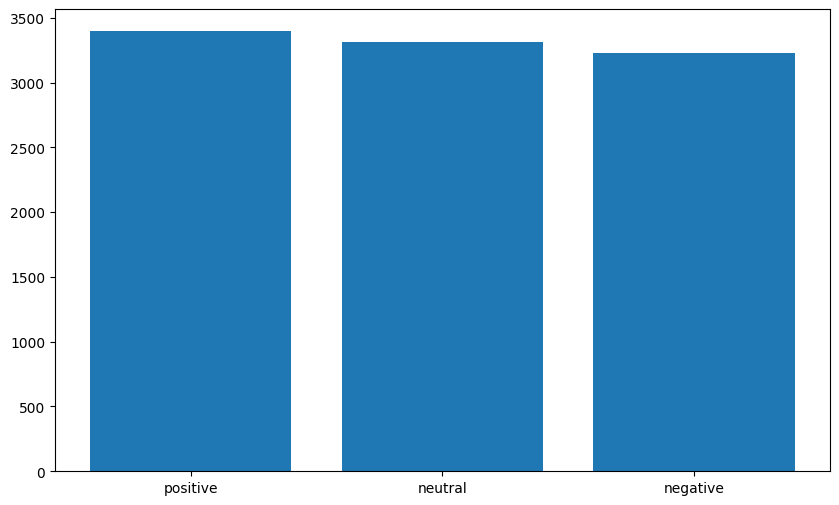

In [5]:
distribution = dataset.sentiment.value_counts() # value_counts() is a pandas function
plt.figure(figsize=(10,6))
plt.bar(distribution.index, distribution.values)


In [6]:
#Encode labels neutral=1, negative=0,positive=2
label=LabelEncoder()
dataset['sentiment'] = label.fit_transform(dataset['sentiment'])

# check the updated labels
dataset


,sentiment,tweet
0,1,"Picturehouse's, Pink Floyd's, 'Roger Waters: T..."
1,0,If these runway renovations at the airport pre...
2,0,Bad Blood may have the absolute worst lyricism...
3,0,My parents are going to the Zac Brown Band con...
4,0,The growth of gerontocracy: George Osborne's a...
...,...,...
9933,1,@ShaquilleHoNeal from what I think you're aski...
9934,2,"Iran ranks 1st in liver surgeries, Allah bless..."
9935,1,Hours before he arrived in Saudi Arabia on Tue...
9936,0,@VanityFair Alex Kim Kardashian worth how to ...


####**Pre-process the Data** 


In [7]:
# Convert to lowercase, remove punctuation, noise, such as non-alphanumeric characters, 
# urls, and double white spaces. Remove stopwords

# Downloads needed when running script on browser
nltk.download('punkt') 
nltk.download('averaged_perceptron_tagger') 
nltk.download('wordnet')

def preprocess(tweet): 
    
    tweet = re.sub(r"[Ww]on't","willn't", str(tweet))# 1st step to expand "won't"
    tweet = re.sub(r"n't",' not', str(tweet)) # expand negative contractions
    tweet = re.sub(r"'s",'s' , str(tweet)) # remove apotrophe in possessives, but keep 's'
    tweet = re.sub(r"(@\S+|#\S+)",' ',str(tweet)) #remove hashtags and users: @ and #
    tweet = re.sub(r"\s\s+",' ',str(tweet)) # replace more than two spaces with one
    tweet = re.sub(r"([^a-zA-z0-9]+|https?:\S+)",' ',str(tweet).lower()).strip() #remove urls
    
    sent = TextBlob(tweet) # lemmatize text
    tag_dict = {"JJ": 'a', 
                "NN": 'n', 
                "V":  'v', 
                "R":  'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'a')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    tweet =  " ".join(lemmatized_list)
    tweet = remove_stopwords(tweet) # remove stopwords (to be done after lemmatizing)


    
    return tweet

# Use lambda to run preprocess function on each row of the dataset tweets
dataset.tweet = dataset.tweet.apply(lambda x: preprocess(x))
#print(dataset.tweet)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

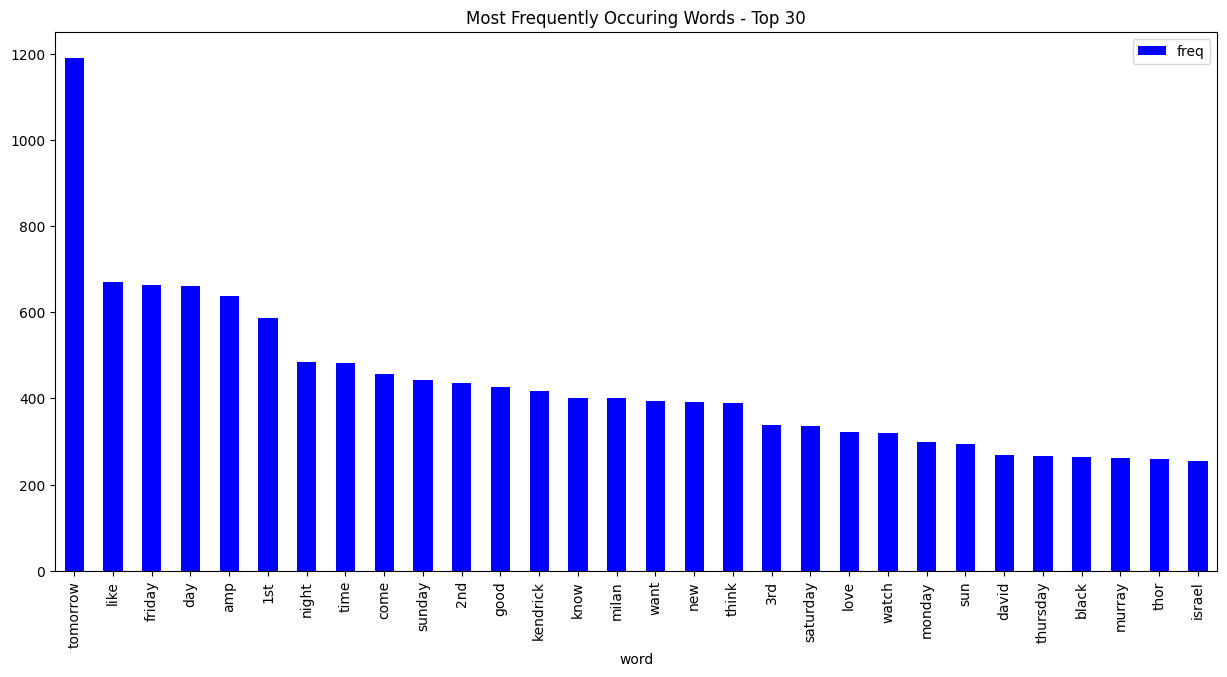

In [8]:
# Gather stopwords

tweets = dataset.tweet  # extract tweets only
vectorizer = CountVectorizer(stop_words = 'english') #
words = vectorizer.fit_transform(tweets) ## stopwords are extracted from training data instead of nltk


sum_words = words.sum(axis=0)

word_freq = [(word, sum_words[0, i]) for word, i in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(word_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")


In [9]:
#explore lengths of tweets and plot them by length

tweet_lengths = []
for index, row in dataset.iterrows():
    tweet_lengths.append(len(row['tweet']))



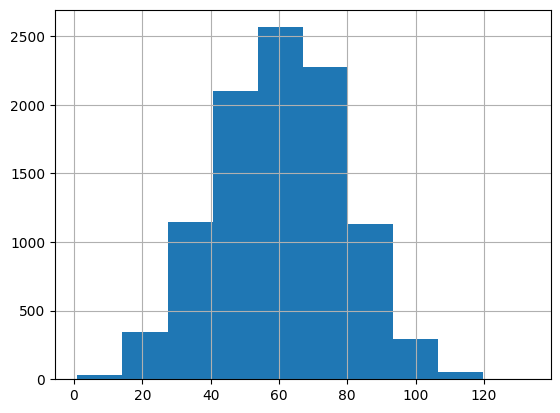

count    9938.000000
mean       60.396559
std        18.705329
min         1.000000
25%        47.000000
50%        60.000000
75%        74.000000
max       133.000000
dtype: float64

In [10]:
#rev_len = [len(i) for i in x_train]
pd.Series(tweet_lengths).hist()
plt.show()
pd.Series(tweet_lengths).describe()

Text(0.5, 1.0, 'Vocabulary from Tweets')

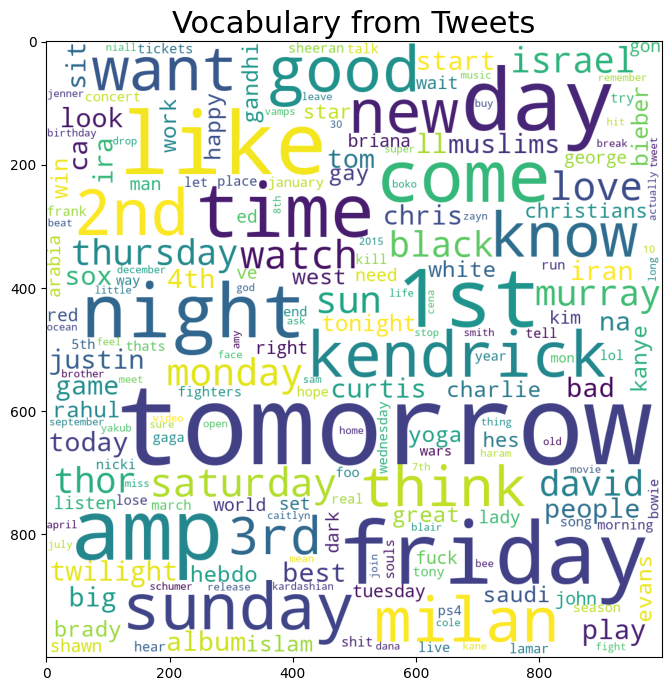

In [11]:

wordcloud = WordCloud(background_color = 'white', width = 1000, 
                      height = 1000).generate_from_frequencies(dict(word_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("Vocabulary from Tweets", fontsize = 22)

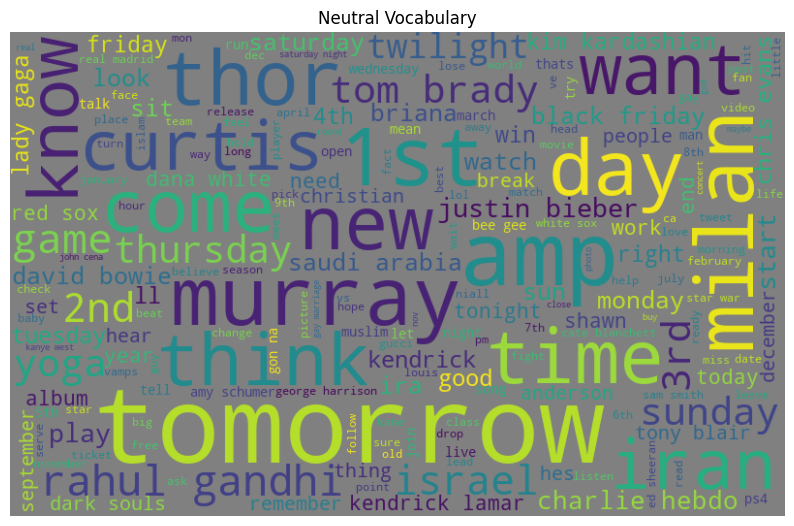

In [12]:
neutral_vocab =' '.join([text for text in dataset['tweet'][dataset['sentiment'] == 1]])

wordcloud = WordCloud(background_color = 'grey', width=800, height=500, 
                      random_state = 0, max_font_size = 110).generate(neutral_vocab)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Neutral Vocabulary')
plt.show()

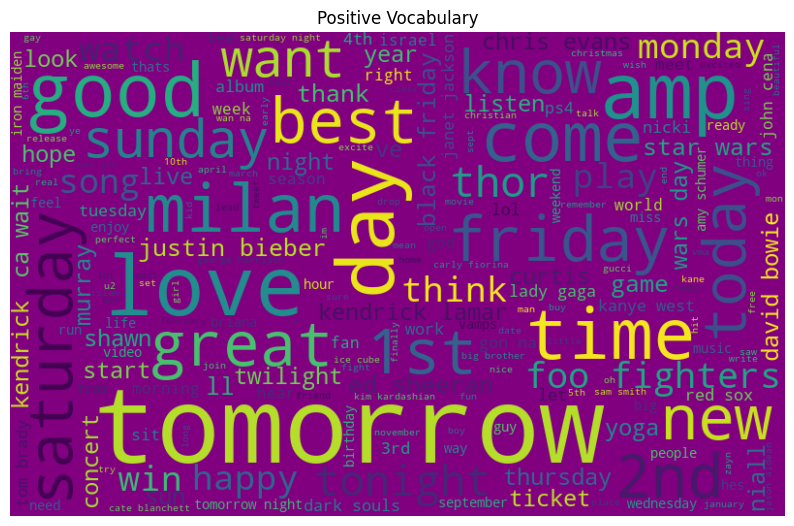

In [13]:
positive_vocab =' '.join([text for text in dataset['tweet'][dataset['sentiment'] == 2]])

wordcloud = WordCloud(background_color = 'purple', width=800, height=500, 
                      random_state = 0, max_font_size = 110).generate(positive_vocab)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Positive Vocabulary')
plt.show()

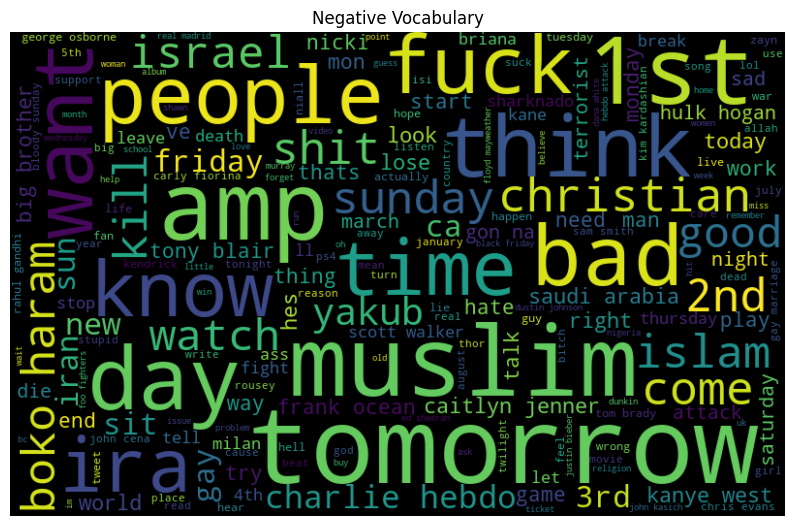

In [14]:
negative_vocab =' '.join([text for text in dataset['tweet'][dataset['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 1, 
                      max_font_size = 110).generate(negative_vocab)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Negative Vocabulary')
plt.show()

##Create Word Index and Embeddings


In [15]:


def build_word_index(data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    word_index = tokenizer.word_index # dictionary mapping each word to an integer
    
    return word_index
    

word_to_int= build_word_index(dataset.tweet)

    

In [16]:
def build_embeddings(word_dict):
    embeddings_dict = {}
    # Open the glove embeddings text file
    file = open('dataset/glove.6B.300d.txt')
    for line in file:
        # Read in each line, split words add to a list
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = vector
    file.close()
    print('Found %s word vectors.' %len(embeddings_dict))
    
    vocab_size = len(word_dict) + 1
    # creating a matrix with zeroes of shape vocab x embedding dimension
    embedding_matrix = np.zeros((vocab_size, 300)) #each embedding vector is of length 300
    # Iterate through word, index in the dictionary
    for word, i in word_dict.items():
       # use word from word_dict to search for its corresponding vector in embeddings
        embedding_vector = embeddings_dict.get(word) 
        if embedding_vector is not None:
            # Storing it in a matrix
            embedding_matrix[i] = embedding_vector 
    return embedding_matrix,embeddings_dict,vocab_size

embeddings,embeddings_dict,vocab_size = build_embeddings(word_to_int)

#Check that mappings look right
#print('embedding_matrix for int 7, which corresponds to "friday"',embeddings[7])
#print('embedding_dict vector for "friday"',embeddings_dict['friday'])

#Verify that the vectors for integer 7 are equal to those for 'Friday'
if list(embeddings[7]) == list(embeddings_dict['friday']):
    print('True')




Found 400000 word vectors.


In [17]:
#build word dictionary based on word_index and 
#pass them into the padded sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset.tweet)
word_index = tokenizer.word_index

#print(word_index)
#print(word_to_int)



#### **Split data into training and testing**



In [18]:


# Splitting the data into training and testing sets
dataset = shuffle(dataset)
train_data, test_data = train_test_split(dataset, test_size=0.2,random_state=16)


print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

#General check
print(type(train_data)) # still a pandas object
print(type(test_data)) # still a pandas object

# check that the train_data looks ok
train_data.tweet

Train Data size: 7950
Test Data size 1988
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


8289    inter v lazio inter clubs big day milan league...
7148    wales content similarities tpabs difference ke...
1590    islamic dictionary peace mean share surrendere...
8978    beat 1st boss dark souls yep understand people...
2683    abuja aug 30 reuters nigerias security agency ...
                              ...                        
2448    miss hopecity sunday check awesome message chr...
4537    like video direction wave fans window hotel mi...
9135    course use fact today thursday thors day celeb...
7328    2nd time milan v spurs san siro zlatan equalis...
4194    murray set lose 5 2 2nd set 6 8 anderson hard ...
Name: tweet, Length: 7950, dtype: object

#### **Split training and testing into input data (features) and target data (labels)**

In [19]:
# Create placeholders for padded sequences of chosen length 

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.tweet),maxlen = 60)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.tweet),maxlen = 60)

# Create target data for training and testing
y_train = train_data.sentiment
y_test = test_data.sentiment


# convert target data into array
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# reshape from 1D to 2D
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1,1)

#General check for datatypes and shapes
print("y_train type",type(y_train))
print("y_test type",type(y_test))
print("x_train type",type(x_train))
print("x_train type",type(x_train))

print('x_train shape',x_train.shape)
print('y_train shape',y_train.shape)
print('x_test shape',x_test.shape)
print('y_test shape',y_test.shape)


y_train type <class 'numpy.ndarray'>
y_test type <class 'numpy.ndarray'>
x_train type <class 'numpy.ndarray'>
x_train type <class 'numpy.ndarray'>
x_train shape (7950, 60)
y_train shape (7950, 1)
x_test shape (1988, 60)
y_test shape (1988, 1)


####**Define the model** 

In [20]:

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D




model = Sequential()
model.add(layers.Embedding(vocab_size,300,weights=[embeddings], input_length = 60))


model.add(SpatialDropout1D(0.4)) 
model.add(LSTM(64, activation='relu', return_sequences=True,dropout=0.2, recurrent_dropout=0.2)) 
model.add(LSTM(128,activation='relu', return_sequences=True)) 
model.add(LSTM(128,activation='relu'))
model.add(Dense(3,activation='softmax')) # 3 classes will be output
opt = Adam(learning_rate=0.01)
#sparse_categorical_crossentropy 
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 300)           4165800   
                                                                 
 spatial_dropout1d (SpatialD  (None, 60, 300)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 60, 64)            93440     
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                        

In [21]:
reduce_lr = ReduceLROnPlateau(factor=0.1,min_lr = 0.0000001, monitor = 'val_loss',verbose = 1) #to reduce learning rate when a metric has stopped improving.
es = callbacks.EarlyStopping(monitor='loss', patience=1)
batch_size=60
model.fit(x_train, y_train, epochs = 3, batch_size=batch_size, callbacks=[reduce_lr,es],validation_data=(x_test, y_test),verbose=True)



Epoch 1/3
133/133 [==============================] - 61s 427ms/step - loss: 1.0120 - accuracy: 0.4704 - val_loss: 0.8697 - val_accuracy: 0.5805 - lr: 0.0100
Epoch 2/3
133/133 [==============================] - 55s 412ms/step - loss: 0.8441 - accuracy: 0.6333 - val_loss: 0.8869 - val_accuracy: 0.5921 - lr: 0.0100
Epoch 3/3
133/133 [==============================] - 56s 419ms/step - loss: 0.5946 - accuracy: 0.7533 - val_loss: 0.8944 - val_accuracy: 0.6187 - lr: 0.0100


In [22]:

# Evaluate the model on the test data using "evaluate"
# current results: test loss, test acc: [1.0018061430731646, 0.5018216967582703]
# results with tanh and sigmoid: val_loss: 1.4862 - val_accuracy: 0.5025
# results with tanh and softmax: val_loss: 2.1204 - val_accuracy: 0.4996
#loss, test acc: [1.0983806536854512, 0.5093287825584412
# 50 epochs/layers at 64 and 128 units: loss, test acc: [1.0747869047091434, 0.5093287825584412]
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=500)
print("test loss, test acc:", results)


Evaluate on test data
4/4 [==============================] - 0s 29ms/step - loss: 0.8944 - accuracy: 0.6187
test loss, test acc: [0.8944419026374817, 0.6187122464179993]


              precision    recall  f1-score   support

    negative       0.70      0.77      0.73       664
     neutral       0.49      0.57      0.53       645
    positive       0.69      0.52      0.59       679

    accuracy                           0.62      1988
   macro avg       0.63      0.62      0.62      1988
weighted avg       0.63      0.62      0.62      1988



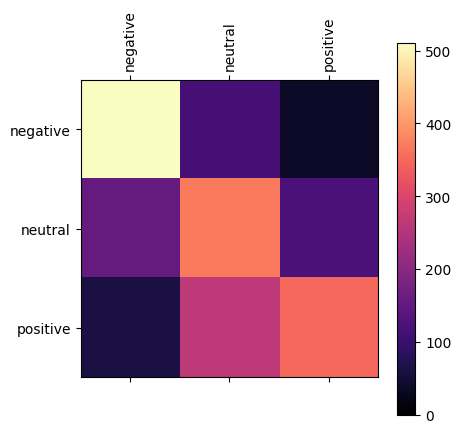

In [23]:

from sklearn.metrics import classification_report

labels = {'negative':0,'neutral':1, 'positive':2}

# given trained model "model" and test vector "x_test" with corresponding "y_test"
# where "y_test" and "y_predicted" are integers whose labels are indexed in 
# 'labels'
y_predicted = tensorflow.argmax(model.predict(x_test), axis=1)

# Confusion matrix
cf = tensorflow.math.confusion_matrix(y_test, y_predicted)
plt.matshow(cf, cmap='magma')
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels=labels, rotation=90)
plt.yticks(np.arange(len(labels)), labels=labels)
plt.clim(0, None)

# Report
print(classification_report(y_test, y_predicted, target_names=labels))